In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor,Resize, Grayscale, Normalize
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
from torch.utils.data import Dataset
import glob
import cv2
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
"""
from google.colab import drive
drive.mount('/content/gdrive')

import zipfile
import os
zip_file = "/content/gdrive/MyDrive/base_v2.1.zip"
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

root_dir = "base_v2.1"
train_data = VisionDataset(root = os.path.join(root_dir,'train_x1'),
                         transform= transforms)
"""
print("Done")

Done


In [6]:
# This import also use in detect_nn.py
from model import CNN, transforms
# If you want change torch model, change model.py

In [7]:
class PCBDataset(Dataset):
    def __init__(self, classes_paths, transforms=None, target_transform=None):
        #print(glob.glob(data_dir))
        self.classes = []
        self.classes_paths = classes_paths
        self.images = []
        self.transform = transforms
        for actual_class in classes_paths:
            if actual_class == 1:
                print("")
            paths = classes_paths[actual_class]
            for path in paths:
                # print("Loading " + path)
                for top, dirs, files in os.walk(path):
                    for i, name in enumerate(files):
                        if not os.path.isfile(top + "//" + name):
                            continue
                        try:
                            imag = cv2.imread(top + "//" + name)
                        except Exception:
                            continue
                        self.images.append(imag)
                        self.classes.append(actual_class)
        self.images = np.array(self.images, dtype=object)
        self.classes = torch.tensor(np.array(self.classes), dtype=torch.int64)
        self.plot_disbalance()


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.transform==None:
            return self.images[idx], self.classes[idx]
        else:
            return self.transform(np.array(self.images[idx]).astype(np.float32)), self.classes[idx]
        
    def plot_disbalance(self):
        heights = []
        labels = []
        incorrect_sum = 0
        for path in self.classes_paths[0]:
            incorrect_sum += len(glob.glob(os.path.join(path, '*')))
        heights.append(incorrect_sum)
        labels.append('incorrect')
        for i in range(1, len(self.classes_paths)-1, 1):
            path = os.path.normpath(self.classes_paths[i][0])
            labels.append(path.split(os.sep)[2])
            heights.append(len(glob.glob(os.path.join(self.classes_paths[i][0], '*'))))
        plt.bar(range(len(heights)), heights)
        plt.ylabel('count images')
        plt.xticks(range(len(heights)), labels, rotation='vertical')
        plt.show()
        

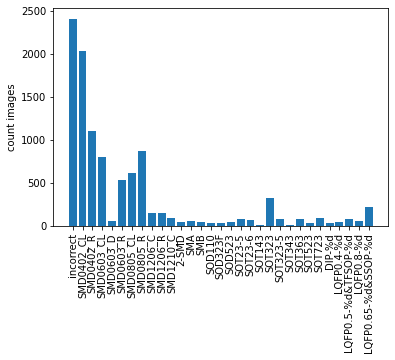

In [8]:
CLASSES_PATHS = {
    0: ["base_v2.1//train_x1//2-SMD//incorrect",
        "base_v2.1//train_x1//SMA//incorrect",
        "base_v2.1//train_x1//SMB//incorrect",
#         "base_v2.1//train_x1//SOD110//incorrect",
#             "base_v2.1//train_x1//SOD323F//incorrect",
#             "base_v2.1//train_x1//SOD523//incorrect",
#             "base_v2.1//train_x1//SOT23-5//incorrect",
#             "base_v2.1//train_x1//SOT23-6//incorrect",
#             "base_v2.1//train_x1//SOT143//incorrect",
#             "base_v2.1//train_x1//SOT323//incorrect",
#             "base_v2.1//train_x1//SOT323-5//incorrect",
#             "base_v2.1//train_x1//SOT343//incorrect",
#             "base_v2.1//train_x1//SOT363//incorrect",
#             "base_v2.1//train_x1//SOT523//incorrect",
#             "base_v2.1//train_x1//SOT723//incorrect",
#             "base_v2.1//train_x1//SMD0402_CL//incorrect",
#             "base_v2.1//train_x1//SMD0402_R//incorrect",
#             "base_v2.1//train_x1//SMD0603_CL//incorrect",
#             "base_v2.1//train_x1//SMD0603_D//incorrect",
#             "base_v2.1//train_x1//SMD0603_R//incorrect",
#             "base_v2.1//train_x1//SMD0805_CL//incorrect",
#         "base_v2.1//train_x1//SMD0805_R//incorrect",
        "base_v2.1//train_x1//SMD1206_C//incorrect",
        "base_v2.1//train_x1//SMD1206_R//incorrect",
        "base_v2.1//train_x1//SMD1210_C//incorrect"],
    1: ["base_v2.1//train_x1//SMD0402_CL//correct"],
    2: ["base_v2.1//train_x1//SMD0402_R//correct"],
    3: ["base_v2.1//train_x1//SMD0603_CL//correct"],
    4: ["base_v2.1//train_x1//SMD0603_D//correct"],
    5: ["base_v2.1//train_x1//SMD0603_R//correct"],
    6: ["base_v2.1//train_x1//SMD0805_CL//correct"],
    7: ["base_v2.1//train_x1//SMD0805_R//correct"],
    8: ["base_v2.1//train_x1//SMD1206_C//correct"],
    9: ["base_v2.1//train_x1//SMD1206_R//correct"],
    10: ["base_v2.1//train_x1//SMD1210_C//correct"],
    11: ["base_v2.1//train_x1//2-SMD//correct"],
    12: ["base_v2.1//train_x1//SMA//correct"],
    13: ["base_v2.1//train_x1//SMB//correct"],
    14: ["base_v2.1//train_x1//SOD110//correct"],
    15: ["base_v2.1//train_x1//SOD323F//correct"],
    16: ["base_v2.1//train_x1//SOD523//correct"],
    17: ["base_v2.1//train_x1//SOT23-5//correct"],
    18: ["base_v2.1//train_x1//SOT23-6//correct"],
    19: ["base_v2.1//train_x1//SOT143//correct"],
    20: ["base_v2.1//train_x1//SOT323//correct"],
    21: ["base_v2.1//train_x1//SOT323-5//correct"],
    22: ["base_v2.1//train_x1//SOT343//correct"],
    23: ["base_v2.1//train_x1//SOT363//correct"],
    24: ["base_v2.1//train_x1//SOT523//correct"],
    25: ["base_v2.1//train_x1//SOT723//correct"],
    26: ["base_v2.1//train_x1//DIP-%d//correct"],
    27: ["base_v2.1//train_x1//LQFP0.4-%d//correct"],
    28: ["base_v2.1//train_x1//LQFP0.5-%d&TFSOP-%d//correct"],
    29: ["base_v2.1//train_x1//LQFP0.8-%d//correct"],
    30: ["base_v2.1//train_x1//LQFP0.65-%d&SSOP-%d//correct"],
    31: ["base_v2.1//train_x1//SOIC-%d//correct"]
}

dataset = PCBDataset(CLASSES_PATHS, transforms)

In [9]:
def validate(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def test(model, loss_function, epochs , tag = "detection"):
    correct = 0
    total = 0
    loss_test = []
    for epoch in range(epochs):
        ep_loss = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
          # calculate outputs by running images through the network
                outputs = model(images)
                loss = loss_function(outputs, labels)
                ep_loss += loss.item()
          # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        loss_test.append(ep_loss /len(test_loader))
        print(f"Epoch={epoch} loss={loss_test[epoch]:.4}")
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    return loss_test

In [10]:
def train(model, loss_function, optimizer, epochs):
    loss_hist = []
    test_accuracy = []
    train_accuracy = []
    for epoch in range(epochs):
        ep_loss = 0
        for images, labels in  tqdm(train_loader): # get bacth
            optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.
            outputs = model.forward(images) # call forward inside
            loss = loss_function(outputs, labels) # calculate loss
            loss.backward() # calculate gradients
            optimizer.step() # performs a single optimization step (parameter update).
            ep_loss += loss.item()
        loss_hist.append(ep_loss /len(train_loader))
        print(f"Epoch={epoch} loss={loss_hist[epoch]:.4}")
        test_accuracy.append(validate(model, test_loader))
        train_accuracy.append(validate(model, train_loader))
    return test_accuracy,train_accuracy, loss_hist

In [11]:
param = 0.9
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [int(len(dataset) * param),
                                                                      len(dataset) - int(len(dataset) * param)])
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [12]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 1, 32, 32])
Labels batch shape: torch.Size([32])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [16]:
model = CNN()
EPOCHS = 10
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().cuda()
test_accuracy, train_accuracy, loss_hist = train(model, criterion, optimizer, epochs=EPOCHS)

torch.Size([1, 512])


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [02:01<00:00,  2.46it/s]


Epoch=0 loss=0.8277


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:54<00:00,  2.60it/s]


Epoch=1 loss=0.3616


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [02:11<00:00,  2.27it/s]


Epoch=2 loss=0.2555


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:54<00:00,  2.60it/s]


Epoch=3 loss=0.1842


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [02:04<00:00,  2.39it/s]


Epoch=4 loss=0.1442


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:56<00:00,  2.56it/s]


Epoch=5 loss=0.1154


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [02:04<00:00,  2.39it/s]


Epoch=6 loss=0.08991


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:56<00:00,  2.55it/s]


Epoch=7 loss=0.07865


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [01:09<00:00,  4.26it/s]


Epoch=8 loss=0.08082


100%|████████████████████████████████████████████████████████████████████████████████| 298/298 [00:08<00:00, 37.07it/s]


Epoch=9 loss=0.06007


In [17]:
validate(model, test_loader)

0.9272211720226843

In [18]:
acc_by_class = {}
if 1 not in acc_by_class:
    acc_by_class[1] = 'fdf'

In [19]:
def validate_by_class(model, dataset_test):
    acc_by_class = {}
    
    with torch.no_grad():
        model.eval()
        for image, label in dataset_test:
            outputs = model(image.unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted.squeeze() == label).sum().item()
            
            if int(label) not in acc_by_class:
                acc_by_class[int(label)] = (correct, 1)
            if int(label) in acc_by_class:
                correct_prev, total_prev = acc_by_class[int(label)]
                acc_by_class[int(label)] = (correct_prev + correct, total_prev + 1)
    return acc_by_class

In [20]:
# d = validate_by_class(model, dataset_test)
# for key in CLASSES_PATHS.keys():
#     try:
#         print(CLASSES_PATHS[key], d[key])
#     except:
#         print(CLASSES_PATHS[key], 'NOT FOUND')

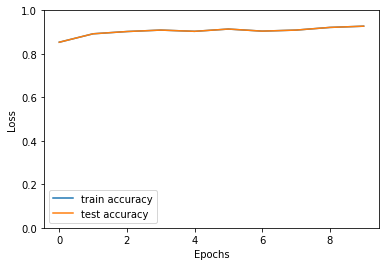

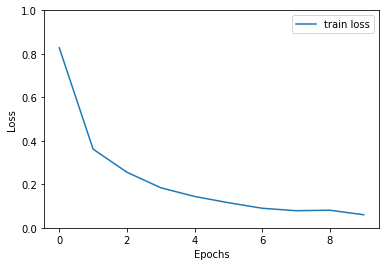

In [24]:
plt.plot(range(EPOCHS), train_accuracy, label='train accuracy')
plt.plot(range(EPOCHS), test_accuracy, label='test accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.plot(range(EPOCHS), loss_hist, label='train loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.show()

#### Save model and try to load

Эта сложная конструкция ниже предназначена для сохранения нейронки и файла с метаинформацией, по которой можно правильно загрузить нейронку в epdetection

In [29]:
import json
from model_info.model_info import ModelInfo

with open("model_info/compatible_det_info.json") as f:
    model_info = ModelInfo("Andrey Marakulin", json.load(f))
    model_info.compile_info()
    model_info.save_info()
    model_name = model_info.get_info()['modelname']
    
torch.save(model.state_dict(), model_name)

Info saved in:  .\model_2022-07-25.pth.schema.json


In [27]:
# Simple test
model_test = CNN()
model_test.load_state_dict(torch.load(model_name))
model_test.eval()
model_test(torch.rand((1, 1, 32, 32)))

torch.Size([1, 512])


tensor([[ 8.5350, -5.8278, -2.7983, -2.0516, -4.5155, -6.0458, -1.6924, -6.6833,
         -3.6744, -3.5959, -5.0205, -7.4266, -4.3911, -5.7168, -6.4002, -6.7893,
         -8.3920, -8.4998, -6.6318, -5.5433, -7.1563, -7.4629, -5.9876, -5.3910,
         -4.6598, -4.4067, -9.4675, -7.1900, -5.4291, -7.5291, -5.9892, -4.9869]],
       grad_fn=<AddmmBackward0>)